# Milestone 1
ggroup 5_

_Authors: Vignesh, Dustin, Aidan, Javairia_

### Disclaimer

Running the entire notebook is very memory intensive. We were only able to achieve this one some of our team's laptops and even then had to do at least the following:
- Shut down Google chrome tabs other than jupyter lab to free up memory
- Shut down slack and other messaging apps
- Shut down zoom to free up memory
- Run only jupyter lab and nothing else

## Section 1: Download the Data

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
from memory_profiler import memory_usage

In [1]:
# code adapted from source 4 

article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "../data/"

response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    #print(file)
    if file["name"] in files_to_dl:
        print(file['name'])
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])


with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

data.zip


## Section 2: Combining the Data with Dask 

In [2]:
import dask.dataframe as dd

In [4]:
# Select column names
use_cols = ['time', 'lat_min', 'lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']

# Get extension for all files
all_files = "../data/*NSW.csv"

# Combine all files
ddf = dd.read_csv(all_files, assume_missing=True, usecols=use_cols, include_path_column=True, dtype={'lat_min': 'object'})

# Create model column
ddf['model'] = ddf['path'].str.rpartition("/")[2].str.partition("_")[0]

# Drop path column
ddf = ddf.drop(['path'], axis=1)

# Write combined data to single file
ddf.to_csv("../data/combined_NSW.csv", single_file=True)

['C:/Users/vignesh/career/figshare-group-5/data/combined_NSW.csv']

## Section 3: Loading the combined CSV to memory

In [ ]:
!pip install matplotlib

In [5]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext rpy2.ipython
%load_ext memory_profiler

C:\Users\vignesh\miniconda3\envs\525\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


### Loading in Chunks

In [6]:
def get_counts(column, file = "../data/combined_NSW.csv"):
    counts = pd.Series(dtype=int)

    for chunk in pd.read_csv(file, chunksize=200_000):
        counts = counts.add(chunk[column].value_counts(), fill_value=0)

    return counts

In [7]:
chunk_mem = %memit -o get_counts('lat_max')
chunk_time = %timeit -o -n1 -r1 get_counts('lat_max')

C:\Users\vignesh\miniconda3\envs\525\lib\site-packages\memory_profiler.py:336: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  returned = f(*args, **kw)


peak memory: 614.86 MiB, increment: 89.00 MiB


C:\Users\vignesh\miniconda3\envs\525\lib\site-packages\IPython\core\magics\execution.py:1169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  time_number = timer.timeit(number)
C:\Users\vignesh\miniconda3\envs\525\lib\timeit.py:205: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  t = self.timeit(number)


1min 55s ± 4.83 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Dask

In [9]:
dask_mem = %memit -o dd.read_csv("../data/combined_NSW.csv", dtype={'lat_min': 'object'})['lat_max'].value_counts().compute()
dask_time = %timeit -o -n1 -r1 dd.read_csv("../data/combined_NSW.csv", dtype={'lat_min': 'object'})['lat_max'].value_counts().compute()

C:\Users\vignesh\miniconda3\envs\525\lib\site-packages\dask\core.py:121: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


peak memory: 2163.93 MiB, increment: 815.00 MiB


C:\Users\vignesh\miniconda3\envs\525\lib\site-packages\dask\core.py:121: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


1min 17s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Loading only columns of interest

In [10]:
col_subset_mem = %memit -o pd.read_csv("../data/combined_NSW.csv", usecols=['lat_max'])['lat_max'].value_counts()
col_subset_time = %timeit -o -n1 -r1 pd.read_csv("../data/combined_NSW.csv", usecols=['lat_max'])['lat_max'].value_counts()

peak memory: 2338.55 MiB, increment: 994.09 MiB
1min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Loading with `low_memory=True`

In [11]:
low_mem = %memit -o pd.read_csv("../data/combined_NSW.csv", usecols=['lat_max'],low_memory=True)['lat_max'].value_counts()
low_time = %timeit -o -n1 -r1 pd.read_csv("../data/combined_NSW.csv", usecols=['lat_max'],low_memory=True)['lat_max'].value_counts()

peak memory: 2236.45 MiB, increment: 891.97 MiB
1min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Comparison

In [12]:
analysis = pd.DataFrame({
    "Method": ["Chunking", "Dask", "Subsetting Columns", "Low Memory"],
    "Time": [np.mean(chunk_time.all_runs), np.mean(dask_time.all_runs), np.mean(col_subset_time.all_runs), np.mean(low_time.all_runs)],
    "Memory": [chunk_mem.mem_usage[0], dask_mem.mem_usage[0], col_subset_mem.mem_usage[0], low_mem.mem_usage[0]]
})

analysis

,Method,Time,Memory
0,Chunking,115.337964,614.859375
1,Dask,77.011799,2163.933594
2,Subsetting Columns,62.156171,2338.550781
3,Low Memory,60.290638,2236.445312


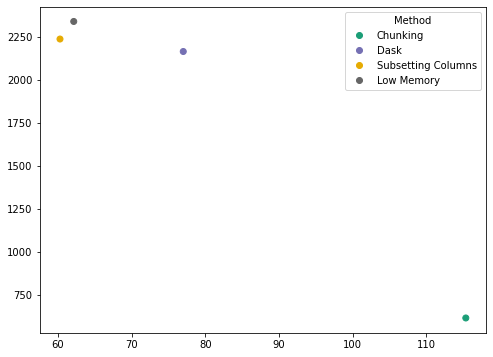

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(analysis.Time, analysis.Memory, c = pd.Categorical(analysis.Method).codes, cmap='Dark2')
ax.legend(sc.legend_elements()[0], analysis.Method, title="Method")
plt.show()

### Discussion

From the experiments, The slowest was chunking. This makes sense since we would have to do multiple iterations to get through the entire data. However, the trade off was the amount of memory used: Chunking used the least amount of memory among all methods tested. 

The fastest method was loading only the column of interest. This was faster than using Dask. The use of `low_memory=True` did not affect the memory usage by much. If we were to pick one of these methods, it would be the column sub-setting method. 

In [2]:
merge = pd.read_csv("../data/combined_NSW.csv", usecols=['model'])

## Section 4: Transfer from Python to R

In [19]:
%%R

install.packages('arrow')
install.packages('feather')

R[write to console]: Warning:
R[write to console]:  package 'arrow' is in use and will not be installed

R[write to console]: Installing package into 'C:/Users/vignesh/R/win-library/4.0'
(as 'lib' is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.0/feather_0.3.5.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 879268 bytes (858 KB)

R[write to console]: downloaded 858 KB




package 'feather' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\vignesh\AppData\Local\Temp\RtmpsJ1gcE\downloaded_packages


In [3]:
import pyarrow.feather as feather
import pyarrow as pa
import pyarrow.parquet as pq
import rpy2_arrow.pyarrow_rarrow as pyra

In [6]:
%%R

library(tidyverse)
library(here)
library(feather)
library(arrow)

R[write to console]: -- Attaching packages --------------------------------------- tidyverse 1.3.0 --

R[write to console]: v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

R[write to console]: -- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

R[write to console]: here() starts at C:/Users/vignesh/career/figshare-group-5

R[write to console]: 
Attaching package: 'feather'


R[write to console]: The following objects are masked from 'package:arrow':

    read_feather, write_feather




In [ ]:
# %%time
# %%R -i merge 

# # transfer dataframe to R as python dataframe

# start_time <- Sys.time()
# result <- merge %>% count(model)
# print(result)
# end_time <- Sys.time()
# print(end_time - start_time)

R[write to console]: Error: cons memory exhausted (limit reached?)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'feather' was built under R version 4.0.4 

R[write to console]: Lost warning messages

R[write to console]: Error: no more error handlers available (recursive errors?); invoking 'abort' restart



We've commented out the cell above because it takes too much memory to import the data frame to R.

In [7]:
%%time
# write the dataframe to feather format 

feather.write_feather(merge, '../data/final_data.feather', version=1)

Wall time: 10.6 s


In [17]:
%%time

# write the dataframe to arrow and then parquet format
# code adapted from source 1

table = pa.Table.from_pandas(merge)
pq.write_table(table, '../data/final_data.parquet')

Wall time: 10.2 s


In [18]:
%%time

# write the dataframe to arrow format 
# code adapted from source 4 

final_table = pyra.converter.py2rpy(table)

1
rarrow.ChunkedArray: 0.003000974655151367
Wall time: 22 ms


In [8]:
%%time
%%R 

# transfer dataframe to R as a feather

file_path = here("data", "final_data.feather")
start_time <- Sys.time()
df <- arrow::read_feather(file_path)
result <- df %>% count(model)
print(result)
end_time <- Sys.time()
print(end_time - start_time)

# A tibble: 28 x 2
   model                n
 * <chr>            <int>
 1 ACCESS-CM2     1932840
 2 ACCESS-ESM1-5  1610700
 3 AWI-ESM-1-1-LR  966420
 4 BCC-CSM2-MR    3035340
 5 BCC-ESM1        551880
 6 CanESM5         551880
 7 CMCC-CM2-HR4   3541230
 8 CMCC-CM2-SR5   3541230
 9 CMCC-ESM2      3541230
10 combined       2939495
# ... with 18 more rows
Time difference of 8.043998 secs
Wall time: 8.08 s


In [20]:
%%time
%%R 

# transfer dataframe to R as a parquet 

file_path = here("data", "final_data.parquet")
start_time <- Sys.time()
df <- read_parquet(file_path)
result <- df %>% count(model)
print(result)
end_time <- Sys.time()
print(end_time - start_time)

# A tibble: 28 x 2
   model                n
 * <chr>            <int>
 1 ACCESS-CM2     1932840
 2 ACCESS-ESM1-5  1610700
 3 AWI-ESM-1-1-LR  966420
 4 BCC-CSM2-MR    3035340
 5 BCC-ESM1        551880
 6 CanESM5         551880
 7 CMCC-CM2-HR4   3541230
 8 CMCC-CM2-SR5   3541230
 9 CMCC-ESM2      3541230
10 combined       2939495
# ... with 18 more rows
Time difference of 9.267674 secs
Wall time: 9.3 s


In [21]:
%%time
%%R -i final_table

# transfer dataframe to R from arrow 
# code adapted from source 4

start_time <- Sys.time()
result <- final_table %>% collect() %>% count(model)
print(result)
end_time <- Sys.time()
print(end_time - start_time)

# A tibble: 28 x 2
   model                n
 * <chr>            <int>
 1 ACCESS-CM2     1932840
 2 ACCESS-ESM1-5  1610700
 3 AWI-ESM-1-1-LR  966420
 4 BCC-CSM2-MR    3035340
 5 BCC-ESM1        551880
 6 CanESM5         551880
 7 CMCC-CM2-HR4   3541230
 8 CMCC-CM2-SR5   3541230
 9 CMCC-ESM2      3541230
10 combined       2939495
# ... with 18 more rows
Time difference of 6.151674 secs
Wall time: 6.18 s


In [23]:
%%sh

du -sh ../data/final_data.feather
du -sh ../data/final_data.parquet

253M	../data/final_data.feather
8.0K	../data/final_data.parquet


## Reasoning

From the exploration of the different memory and time usage, we can see that parquet store less memory then the feather files as inferred from the shell command above that tells us the directories' usage. From our research, we infer that this is due to the use of dictionary encoding and certain compressions that make this possible (2). Furthermore, we noticed the time it takes to do a basic query is much faster for parquet and feather files than passing the pandas dataframe through pandas exchange because it may be reading all the rows of the file to get the answer to our simple count query. However, parquet files store the metadata of the file and can easily access the columns since they are stored in a columnar format (3) and read the files without having to loop through everything. However, the time difference between feather and parquet files is minimal. We hypothesize that this may be due to the fact that our files are not large enough for us to see the difference. We have also considered using an arrow exchange to go from Python to R. In general, arrow is great for in-memory computing (5) and we noticed it was faster than parquet and feather files. It is also less expensive to write than the parquet file format (5). We have also found that parquet and arrow files are used together as a way of performing many operations in the arrow format and then storing the file as a parquet for long term archival storage (5). Both parquet and arrow files are easily integratable to Spark which will be used a tool for later milestones (2 & 5). But this arrow exchange only has select operations that can be performed in R and this process is still in development as mentioned in our 525 lecture 2 (4). Overall, the conversion to parquet file was easy, simple and the fastest while allowing us to stick to the normal operations in R to read the data into a dataframe again so because of this and the fact that we don't anticipate no additional data that will be added at a later date, we will be using parquet as our final choice.

## Reflections

We ran into quite a few issues when running the entire notebook with all the data:

1. Downloading and unzipping the data depended on each of our internet speeds and disk speeds. For some of our team this took about 15-20 minutes
2. Merging the files with Dask often ran into memory issues. 
3. There were major memory issues when we tried to import the pandas dataframe to R directly.
4. Because of this, we couldn't try out _all_ possible methods to load an analyze the data. Our conclusions are based on those which we were able to run.

**References**

1. https://stackoverflow.com/questions/41066582/python-save-pandas-data-frame-to-parquet-file
2. https://stackoverflow.com/questions/48083405/what-are-the-differences-between-feather-and-parquet
3. https://luminousmen.com/post/big-data-file-formats
4. https://github.ubc.ca/MDS-2020-21/DSCI_525_web-cloud-comp_students
5. https://stackoverflow.com/questions/56472727/difference-between-apache-parquet-and-arrow